# Playing with the FERC small generators table

This notebook takes the header rows interspersed throughout the data and turns them into actual headers rather than rows with NAN values. In the final output, the columns `manual_map` refers to the column
previously called `plant_type` that was manually mapped by zane. The column called `headers` is the new
column that maps these values programatically.

To compare the programatic mapping against the manual mapping, I created a dictionary that mirrors the type of fuel labels used by Zane in the manual map. You can decide whether to use this one (for compariative
purposes) or another generic one for other (rmi) purposes.

The final `assign_headers_all()` function allows you to not `drop_headers` if you want. This is a good way to check the efficacy of the programatic header mapping. Otherwise, it will automatically remove all of the
header rows from the data along with any of the support columns created along the way.

## Setup...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard libraries
import logging
import sys
import os
import pathlib
import random

# 3rd party libraries
import geopandas as gpd
import dask.dataframe as dd
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa
#import pickle

# Local libraries
import pudl
from pudl.analysis.fill_ferc1_fuel_gaps import *
from pudl.analysis.flag_ferc1_totals import *

# Enable viewing of logging outputs
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

# Display settings
sns.set()
%matplotlib inline
mpl.rcParams['figure.dpi'] = 75
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [3]:
# Establish connection to pudl database
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
pudl_out = pudl.output.pudltabl.PudlTabl(
    pudl_engine=pudl_engine,
    freq='AS'
)

ferc_engine = sa.create_engine(pudl_settings['ferc1_db'])

In [4]:
small_plants_raw = pd.read_sql("f1_gnrt_plant", ferc_engine)
small_plants = pudl_out.plants_small_ferc1()#.dropna(subset=['plant_name_ferc1'])

In [5]:
# View random utility groups! (thanks, Trenton)
def view_random_utility(df):
    df = df.reset_index(drop=True)
    util_groups = df.groupby(['utility_id_ferc1'])
    random_utility = random.choice(list(util_groups.groups.keys()))
    return df.iloc[util_groups.groups[random_utility]]

## Use Zane's transformations without dropping the NA rows...

In [33]:
# Here we create a fake raw dfs dictionary with just the small plants df to run it through
# Zane's existing transform feature.
fake_dict = {'plants_small_ferc1': small_plants_raw}
new_dict = {}
small_plants_dict = pudl.transform.ferc1.plants_small(fake_dict, new_dict)
small_plants_out = small_plants_dict['plants_small_ferc1']

# drop rows with no plant name because we can't use that
small_plants_out = small_plants_out.dropna(subset=['plant_name_original'])

/Users/aesharpe/miniconda3/envs/pudl-dev/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Get rid of rows we know we won't need...

In [34]:
# If these columns are nan, we can assume it is either a header row or isn't useful
nan_cols = ['construction_year', 'net_generation_mwh', 'total_cost_of_plant', 'capex_per_mw', 'opex_total', 
            'opex_fuel', 'opex_maintenance', 'fuel_cost_per_mmbtu']

# Remove utilities with all NAN rows because these won't contain anything meaningful
# spc = small_plants_clean
spc = (
    small_plants_out
    .groupby('utility_id_ferc1').filter(lambda x: ~x[nan_cols].isna().all().all())
)

# Remove rows with ---------- or '' for names
spc = spc[~spc['plant_name_original'].str.contains('------')]
spc = spc[~spc['plant_name_original'].isin(['', 'none', 'na', 'n/a', 'not applicable'])]
spc = spc.reset_index(drop=True)

## Flag total rows...

In [35]:
spc.insert(3, 'is_total', False)
spc.loc[spc['plant_name_original'].str.contains('total'), 'is_total'] = True

## Flag possible headers...

In [36]:
# If a potential header column has these strings, it's probably a useful header
header_strings = ['hydro', 'hyrdo', 'internal', 'wind', 'solar', 'gas', 'diesel', 'diesal', 
                  'steam', 'other', 'combustion', 'combustine', 'fuel cell', 'hydraulic', 
                  'waste', 'landfill', 'photovoltaic', 'nuclear', 'oil', 'renewable', 
                  'facilities']

# If a potential header has these strings, it's not a header...
exclude = ['license', '#', '\*', 'pg', 'solargenix', '\@']

# ...unless it also has one of these strings
exceptions = ['hydro plants: licensed proj. no.', 'hydro license no.', 
              'hydro: license no.', 'hydro plants: licensed proj no.']

# What we will rename the headers once we remove them as rows 
new_header_labels = {
    'hydroelectric': ['hydro', 'hyrdo'],
    'internal combustion': ['internal', 'interal', 'international combustion', ],
    'combustion turbine': ['combustion turbine'],
    'gas turbine': ['gas'],
    'petroleum liquids': ['oil', 'diesel', 'diesal'],
    'solar': ['solar', 'photovoltaic'],
    'wind': ['wind'],
    'geothermal': ['geothermal'],
    'waste': ['waste', 'landfill'],
    'steam': ['steam'],
    'nuclear': ['nuclear']
}

# Header names that match the one's that zane used in his manual mapping (so we can 
# compare processes)
zane_header_labels = {
    'solar_pv': ['solar', 'photovoltaic'],
    'wind': ['wind'],
    'hydro': ['hydro', 'hyrdo'],
    'internal_combustion': ['internal', 'interal', 'international combustion', ],
    'combustion_turbine': ['combustion turbine', 'combustine turbine'],
    'diesel_turbine': ['oil', 'diesel', 'diesal'],
    'gas_turbine': ['gas'],
    'geothermal': ['geothermal'],
    'waste_heat': ['waste', 'landfill'],
    'steam_heat': ['steam'],
    'nuclear': ['nuclear'],
    'fuel_cell': ['fuel cell']
}

In [37]:
# Add some new columns
spc.insert(3, 'is_header', False)
spc.insert(3, 'header_type', np.nan)

# Label possible header rows (based on the nan cols specified above)
spc.loc[spc.filter(nan_cols).isna().all(1), 'is_header'] = True

# Label good header rows (based on whether they contain key strings)
is_header = spc['is_header']
is_good_header = spc['plant_name_original'].str.contains('|'.join(header_strings))
not_bad = ~spc['plant_name_original'].str.contains('|'.join(exclude))

spc.loc[is_header & is_good_header & not_bad, 'header_type'] = 'good_header'
spc.loc[spc['plant_name_original'].isin(exceptions), 'header_type'] = 'good_header'

## Get rid of large clumps of notes or bad headers...

In [38]:
from pudl.analysis.fill_ferc1_fuel_gaps import * 

def get_header_clumps_all(df):
    """
    Remove clumps of consecutive rows flagged as possible headers.
    
    FERC has lots of note rows that are not headers but are also not useful for analysis.
    This function looks for rows flagged as possible headers (based on NAN values) and checks to
    see if there are multiple in a row. A header row is (usually) defined as a row with NAN values
    followed by rows without NAN values, so when there are more than one clumped together they are
    likely either notes or note helpful. There is one exception to this case which is a header that 
    is followed by a plant that had no values reported... Unfortunately I haven't built a work around,
    but hopefully there aren't very many of these. Currently, that header and plant will be categorized
    as clumps and removed.
    
    Sometimes note clumps will end with a meaningful header. This function also checks for this and will
    unclump any headers at the bottom of clumps.
    
    """
    util_groups = df.groupby(['utility_id_ferc1', 'report_year'])
    
    def get_header_clumps(util_year_group):
        #Create mini groups that count pockets of true and false for each utility and year
        # create_groups() is a function from the fill_ferc1_fuel_gaps module-- basically what
        # it does is create a df where each row represents a clump of adjecent, equal values for
        # a given column. Ex: a column of True, True, True, False, True, False, False, will
        # appear as True, False, True, False with value counts for each
        group, header_count = create_groups(util_year_group, 'is_header')
        
        # These are used later to enable exceptions
        max_idx_val = header_count.index.max()
        max_df_val = util_year_group.index.max()
        
        # Create a list of the index values that comprise each of the header clumps
        # It's only considered a clump if it is greater than 1.
        idx_list = list(header_count[
            (header_count['fuel']) & (header_count['val_count'] > 1)].index)
        
        # If the last row is not a clump (i.e. there is just one value) but it is a header (i.e. has nan values)
        # then also include it in the index values to be flagged because it might be a one-liner note. And
        # because it is at the bottom there is no chance it can actually be a useful header because there are
        # no value rows below it.
        last_row = header_count.tail(1)
        if (last_row['fuel'].item()) & (last_row['val_count'].item()==1):
            idx_list = idx_list + list(last_row.index)
        # If there are any clumped/end headers:
        if idx_list:
            for idx in idx_list:
                # Check to see if last clump bit is not a header... sometimes you might find a clump of
                # notes FOLLOWED by a useful header. This next bit will check the last row in each of
                # the identified clumps and "unclump" it if it looks like a valid header. We only need
                # to check clumps that fall in the middle because, as previously mentioned, the last row
                # cannot contain any meaningful header information because there are no values below it.
                idx_range = group.groups[idx+1]
                is_middle_clump = group.groups[idx+1].max() < max_df_val
                is_good_header = util_year_group.loc[
                    util_year_group.index.isin(group.groups[idx+1])].tail(1)['plant_name_original'].str.contains('|'.join(header_strings)).all()  #.isin(header_strings).all()
                # If the clump is in the middle and the last row looks like a header, then drop it from the idx range
                if is_middle_clump & is_good_header:
                    idx_range = [x for x in idx_range if x != idx_range.max()]
                # Label the clump as a clump
                util_year_group.loc[
                    util_year_group.index.isin(idx_range), 'header_type'] = 'clump'
        return util_year_group
    
    return util_groups.apply(lambda x: get_header_clumps(x))

In [39]:
header_clumps = get_header_clumps_all(spc)

In [40]:
# List of things that don't make the cut as headers
bad_headers = list(
    header_clumps[
        (header_clumps['is_header']) 
        & (header_clumps['header_type'].isna())].plant_name_original.unique())

bad_headers.sort()
bad_headers

['(amounts are for the total of all 100 units)',
 '(amounts are for the total of all 102 units)',
 '(amounts are for the total of all 107 units)',
 '(amounts are for the total of all 171 units)',
 '(amounts are for the total of all 193 units)',
 '(amounts are for the total of all 214 units)',
 '(amounts are for the total of all 28 units)',
 '(amounts are for the total of all 4 units)',
 '(amounts are for the total of all 44 units)',
 '(amounts are for the total of all 50 units)',
 '(amounts are for the total of all 51 units)',
 '(amounts are for the total of all 52 units)',
 '(amounts are for the total of all 60 units)',
 '(amounts are for the total of all 64 units)',
 '(amounts are for the total of all 66 units)',
 '(amounts are for the total of all 76 units)',
 '(amounts are for the total of all 84 units)',
 '(amounts are for the total of all 87 units)',
 '(emergency standby units)',
 '* generation is recorded as company use',
 '* license surrendered august 1982.',
 '* mammoth pool',

In [41]:
# List of acceptable headers
good_headers = list(
    header_clumps[
        header_clumps['header_type']=='good_header'].plant_name_original.unique())
good_headers.sort()
good_headers

['additional hydro plant',
 'albany steam hydro expense',
 'auke bay internal combustion',
 'auke bay internal combustion:',
 'black start diesel units',
 'black start diesel units:',
 'combustine turbine',
 'combustion turbine',
 'diesal',
 'diesel',
 'diesel plant',
 'diesel plants',
 'diesel plants:',
 'diesel:',
 'dinner lake gas',
 'fuel cell',
 'fuel cell:',
 'gas plant',
 'gas turbine',
 'gas turbine plant',
 'gas turbine plants',
 'gas turbine:',
 'gas turbines',
 'gas turbines:',
 'gold creek internal combustion:',
 'hydraulic',
 'hydraulic (1):',
 'hydraulic:',
 'hydro',
 'hydro -',
 'hydro electric',
 'hydro lic project no.',
 'hydro license no.',
 'hydro plant:',
 'hydro plants',
 'hydro plants:',
 'hydro plants: licensed proj no.',
 'hydro plants: licensed proj. no.',
 'hydro-electric',
 'hydro:',
 'hydro: lic project no.',
 'hydro: lic. project no.',
 'hydro: license no.',
 'hydroelectric',
 'hydroelectric generating plants',
 'hydroelectric generating plants :',
 'hydroe

## Identify and label plant groups for true headers...

In [42]:
def assign_headers_all(df, header_labels, drop_headers=True):
    """
    Group the data by header and create header column.
    
    This function gets rid of the clumps and turns the header row into a header column.
    It does this by grouping the data into groupby object based on the presence of "good"
    header columns throughout the data. Each group begins with a good header and ends
    right before the next one, if applicable. This doesn't *always* work (see utility id
    120 year 2011) but that's usually because of bad reporting not a program glitch.
    
    The function also cleans up the header names.
    
    remove_headers may be switched to false if you want to double check how well
    the program maps headers / whether there are any glitches.
    
    """
    # Start by dropping the clumps
    df = df.drop(df[(df['is_header']) & (df['header_type']=='clump')].index).reset_index(drop=True)
    
    # Turn good headers into booleans
    df['is_good_header'] = False
    df.loc[df['header_type']=='good_header', 'is_good_header'] = True
    
    # Clean up header names - made a new col just to preserve any of the original names
    for tech in header_labels:
        is_good_header = df['is_good_header']
        has_tech = df['plant_name_original'].str.contains('|'.join(header_labels[tech]))
        df.loc[is_good_header & has_tech, 'header_prep_clean'] = tech
            
    # Note likely header rows that haven't been categorized
    not_mapped = df[(df['header_prep_clean'].isna()) & (df['is_good_header'])]['plant_name_original'].unique()
    print('headers that have not been mapped:', not_mapped)
    
    # Make groups based on the year and whether there is a header
    header_groups = df.groupby(['utility_id_ferc1', 'report_year', df['is_good_header'].cumsum()])

    # Assign that header to the rows that follow
    def assign_header(header_group):
        header_value = header_group[header_group['is_good_header']]['header_prep_clean']
        if not header_value.empty:
            header_group.insert(3, 'header', header_value.item())
        return header_group

    out_df = header_groups.apply(lambda x: assign_header(x))
    
    # Now we can remove the useless rows and headers
    if drop_headers:
        out_df = (
            out_df.dropna(subset=nan_cols, how='all')
            .drop(columns=['is_header', 'header_type', 'is_good_header', 'header_prep_clean'], axis=1))
        
    
    return out_df

In [43]:
def final_touches(df, chosen_label):
    """Add obvious names to headers and move columns around."""
    # Add obvious names to headers
    # This is a little dangerous -- ex: plants like 'solar centaur gas turbine' -- these are hopefully
    # addressed by the order of the fuels in the label dictionary
    for tech in chosen_label:
        df.loc[df['plant_name_original'].str.contains(
                '|'.join(chosen_label[tech])), 'header'] = tech

    # Move the plant type col closer to the front for visual comparison
    df.insert(3, 'manual_map', df.plant_type)

    print('')
    print('header matches manual plant type:', len(df[df['header'] == df['plant_type']]))
    print('total manual plant types:', len(df[df['manual_map'].notna()]))
    print('total headers mapped:', len(df[df['header'].notna()]))
    print('total rows:', len(df))
    print('')
    
    return df

In [44]:
chosen_labels = zane_header_labels

# Assign headers - drop all header columns
assigned_headers_drop = (
    assign_headers_all(header_clumps, chosen_labels)
    .pipe(final_touches, chosen_labels))

assigned_headers = (
    assign_headers_all(header_clumps, chosen_labels, drop_headers=False)
    .pipe(final_touches, chosen_labels))

headers that have not been mapped: ['hydraulic' 'other:' 'other production:' 'lewiston canal facilities:'
 'other' 'hydraulic (1):' 'hydraulic:'
 'other general ops. supervision & engineering' 'other-leased:'
 'renewables' 'renewables:']

header matches manual plant type: 4369
total manual plant types: 6526
total headers mapped: 11638
total rows: 14953

headers that have not been mapped: ['hydraulic' 'other:' 'other production:' 'lewiston canal facilities:'
 'other' 'hydraulic (1):' 'hydraulic:'
 'other general ops. supervision & engineering' 'other-leased:'
 'renewables' 'renewables:']

header matches manual plant type: 4376
total manual plant types: 6533
total headers mapped: 13645
total rows: 17249



In [45]:
# wierd ones: 
# - utility id 120 year 2011 weirdness with dispersed generation getting categorized as gas
# - utility id 224 has rows accidentally split into two...

In [46]:
view_random_utility(assigned_headers)

,utility_id_ferc1,report_year,plant_name_original,manual_map,header,header_type,is_header,is_total,construction_year,capacity_mw,peak_demand_mw,net_generation_mwh,total_cost_of_plant,capex_per_mw,opex_total,opex_fuel,opex_maintenance,fuel_type,fuel_cost_per_mmbtu,plant_name_ferc1,plant_type,ferc_license_id,record_id,is_good_header,header_prep_clean
367,161,1994,unit 7 diesel,NaN,diesel_turbine,NaN,False,False,1958.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,diesel,NaN,unit 7 diesel,NaN,NaN,f1_gnrt_plant_1994_12_161_0_3,False,NaN
368,161,1994,unit 8 diesel,NaN,diesel_turbine,NaN,False,False,1963.0,1.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,diesel,NaN,unit 8 diesel,NaN,NaN,f1_gnrt_plant_1994_12_161_0_4,False,NaN
369,161,1994,unit 10 diesel,NaN,diesel_turbine,NaN,False,False,1966.0,1.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,diesel,NaN,unit 10 diesel,NaN,NaN,f1_gnrt_plant_1994_12_161_0_5,False,NaN
370,161,1994,unit 11 diesel,NaN,diesel_turbine,NaN,False,False,1973.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,diesel,NaN,unit 11 diesel,NaN,NaN,f1_gnrt_plant_1994_12_161_0_6,False,NaN
371,161,1994,unit 12 diesel,NaN,diesel_turbine,NaN,False,False,1976.0,1.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,diesel,NaN,unit 12 diesel,NaN,NaN,f1_gnrt_plant_1994_12_161_0_7,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16770,161,2019,environmental mitigation services,NaN,solar_pv,NaN,False,False,NaN,0.0,0.0,NaN,NaN,NaN,16247312.0,NaN,NaN,,NaN,environmental mitigation services,NaN,NaN,f1_gnrt_plant_2019_12_161_1_21,False,NaN
16771,161,2019,it imm costs,NaN,solar_pv,NaN,False,False,NaN,0.0,0.0,NaN,NaN,NaN,1584223.0,NaN,NaN,,NaN,it imm costs,NaN,NaN,f1_gnrt_plant_2019_12_161_1_22,False,NaN
16772,161,2019,uc santa barbara fuel cell,NaN,fuel_cell,NaN,False,False,2012.0,0.0,0.0,1497954.0,NaN,NaN,100383.0,74315.0,NaN,,NaN,uc santa barbara fuel cell,NaN,NaN,f1_gnrt_plant_2019_12_161_1_23,False,NaN
16773,161,2019,cs san bernardino fuel cell,NaN,fuel_cell,NaN,False,False,2013.0,0.0,0.0,9070841.0,NaN,NaN,18281.0,547478.0,511736.0,,NaN,cs san bernardino fuel cell,NaN,NaN,f1_gnrt_plant_2019_12_161_1_24,False,NaN


In [47]:
#assigned_headers.head(5)

In [65]:
for_chart = (
    assigned_headers_drop
    .assign(header=lambda x: x.header.fillna('unknown'))
)

In [66]:
for_chart.header.unique()

array(['hydro', 'internal_combustion', 'unknown', 'steam_heat',
       'diesel_turbine', 'gas_turbine', 'combustion_turbine', 'solar_pv',
       'wind', 'waste_heat', 'fuel_cell', 'nuclear'], dtype=object)

<AxesSubplot:ylabel='header'>

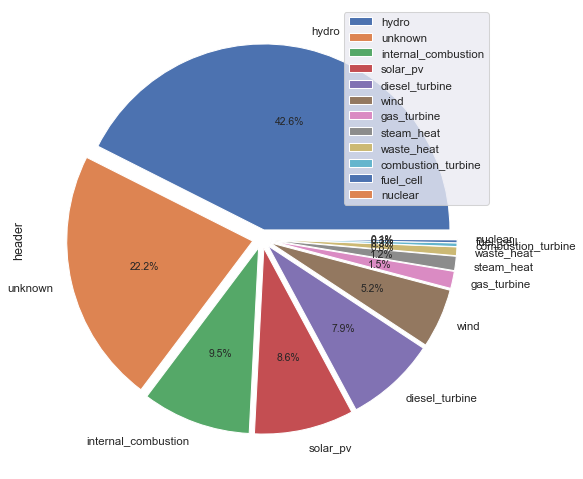

In [76]:
for_chart.header.value_counts().plot(kind='pie', figsize=(8,16), legend=True, autopct='%1.1f%%',
                                     explode=(0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05))

In [64]:
assigned_headers_drop.to_excel('/Users/aesharpe/Desktop/small_gens_with_headers.xlsx')